
# **TAREA 3**

En esta práctica se estudia la evolución de una onda a medida que se acerca a una playa, con un perfil con pendiente constante 1/30. El oleaje se obtiene a partir de la serie suministrada (superficie libre2.txt) en profundidades indefinidas y con un ángulo de incidencia de 30º.

Asumiendo como válidas las hipótesis de la teoría lineal, suponer también lineal el asomeramiento. donde se cumple: Eo Cgo = Ei Cgi.

El oleaje irá ganando altura y perdiendo estabilidad a lo largo del eje X, hasta alcanzar el punto de rotura a la profundidad hb con una altura de ola (Hb) determinada. Aunque hay diferentes métodos para estimar el punto de rotura, utilizar el de Goda (1970)  que viene dado en función de la pendiente de la playa, y el de onda solitaria McCowan (1891). Comparar los resultados.

## **1. A partir de la serie determinar la altura de ola significante en indefinidas y el periodo de pico, por método espectral.**

Lectura del archivo de variacion de la superficie libre.

In [ ]:
import pandas as pd
ruta_archivo = "Superficie_Libre2.txt"
df = pd.read_csv(ruta_archivo, delimiter="\t")

ultima_columna = df.iloc[:, -1]
nuevo_df = pd.DataFrame({'Ultima_Columna': ultima_columna})

print(nuevo_df)

       Ultima_Columna
0              1.6712
1              2.1477
2              1.9387
3              1.8390
4              1.8784
...               ...
25194          1.9380
25195          1.9085
25196          1.8493
25197          1.7801
25198          1.7407

[25199 rows x 1 columns]


Se reconoze que el archivo de datos contiene datos desde 2009-4-19-20:0:0 hasta 2009-4-20-2:59:59 es una medicion de 24 horas con frecuencia cada segundo, en el siguiente bloque de codigo se discretiza el archivo cada hora y se escoge de cada hora los primeros 1024 datos (17 minutos) que corresponden a estados de mar, al final se presenta una grafica con la discretizacion del archivo

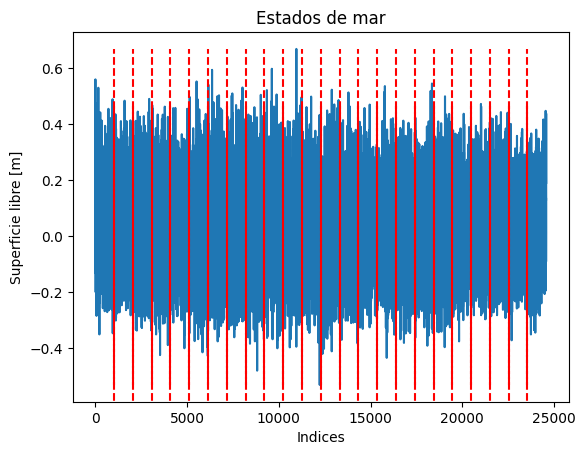

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
datos=nuevo_df.Ultima_Columna.values

num_grupos = 24
grupos = np.array_split(datos, num_grupos)
primeros=[]


for grupo in grupos:
  segmento = grupo[:1024]
  mean = segmento.mean()
  segmento = segmento - mean
  primeros.append(segmento)


todos= np.concatenate(primeros)
indices = np.arange(len(todos))

plt.plot(indices, todos)

# Add vertical lines every 1024 data points, with y-axis limits
for i in range(1024, len(todos), 1024):
    plt.axvline(x=i, color='red', linestyle='--', ymin=-0.4, ymax=0.8)

# Add dashed lines on the x-axis at every 1024 data points
for i in range(1024, len(todos), 1024):
  plt.plot([i, i], [min(todos), max(todos)], 'r--') # 'r--' for red dashed line

# Add labels and title
plt.xlabel("Indices")
plt.ylabel("Superficie libre [m]")
plt.title("Estados de mar")

# Display the plot
plt.show()

En el siguiente bloque se calcula el espectro de cada estado de mar, creamos una funcion llamada espectro que calcula el espectro por analisis de fourier y calcula Hs y Tp utilizando el momento de orden cero.
$$H_s = 4 \sqrt{m_0}$$
y la frecuencia pico como la posicion en donde se encuentra el mayor dato del espectro, se calculo la significante de onda y el periodo pico de la los estados de mar de la primera, cuarta y septima hora con valores:

Primera hora:$H_s = 0.545 m \quad$ y $\quad Tp = 16.787 s$

Cuarta hora: $H_s = 0.633 m \quad$ y $\quad Tp = 15.754 s$

Septima hora: $H_s = 0.639 m \quad$ y $\quad Tp = 16.516 s$

Al final se produce un grafico con los espectros.

Significant Wave Height (Hs) from m0: 0.545 meters
Peak Period (Tp): 16.787 seconds
Significant Wave Height (Hs) from m0: 0.633 meters
Peak Period (Tp): 15.754 seconds
Significant Wave Height (Hs) from m0: 0.639 meters
Peak Period (Tp): 16.516 seconds


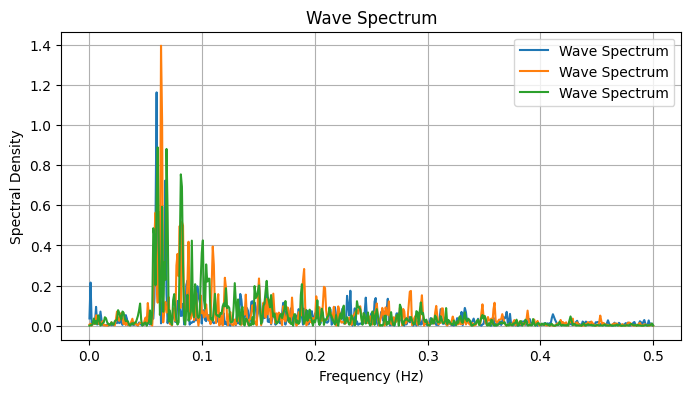

In [ ]:
import re
import seaborn as sns
from scipy.signal import welch

def espectro(datos,dt):
  fs = 1 / dt  # Sampling frequency
  # Extract time and surface displacement
  time = np.arange(0,len(primeros[6]),fs)
  # Compute the Wave Spectrum using Welch's Method
  frequencies, power_spectrum = welch(datos, fs=fs, nperseg=1024)

  # Compute the zeroth spectral moment (m0)
  m0 = np.trapz(power_spectrum, frequencies)  # Numerical integration

  # Compute Significant Wave Height (Hs)
  Hs = 4 * np.sqrt(m0)

  # Find Peak Period (Tp)
  peak_index = np.argmax(power_spectrum)  # Index of max spectral density
  fp = frequencies[peak_index]  # Peak frequency
  Tp = 1 / fp if fp > 0 else np.nan  # Avoid division by zero

  # Print results
  print(f"Significant Wave Height (Hs) from m0: {Hs:.3f} meters")
  print(f"Peak Period (Tp): {Tp:.3f} seconds")
  return frequencies, power_spectrum, Hs, Tp

frequencies, power_spectrum,_ ,_ = espectro(primeros[0],1)
frequencies2, power_spectrum2,_ ,_ = espectro(primeros[3],1)
frequencies3, power_spectrum3,_ ,_ =espectro(primeros[6],1)

# Plot Wave Spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies, power_spectrum, label="Wave Spectrum")
plt.plot(frequencies2, power_spectrum2, label="Wave Spectrum")
plt.plot(frequencies3, power_spectrum3, label="Wave Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Spectral Density")
plt.title("Wave Spectrum")
plt.legend()
plt.grid()
plt.show()

En el siguiente bloque se calculan las longitudes de onda utilizando la relación de dispesión de la teoria lineal, se crea una función que es capaz de encontrar la longitud de onda de manera iterativa resolviendo la relación de disperción de manera numérica, las entradas de la función son la frecuencia y la profundidad. se le entrega un valor de 3000 metros de profundidad para asi calcular la longitud de onda en aguas profundas, los resultados son:

Primera hora: $L1 = 439.80m$

Cuarta hora: $L2 = 387.44m$

Septima hora: $L3 = 425.89m$

In [ ]:
import numpy as np

def longitud_onda(Tp, profundidad):
    """
    Calcula la longitud de onda utilizando la relación de dispersión exacta.

    Args:
        Hs: Altura de ola significativa.
        Tp: Periodo pico.
        profundidad: Profundidad del agua.

    Returns:
        Longitud de onda.
    """
    g = 9.81  # Aceleración debida a la gravedad

    # Función para resolver la relación de dispersión iterativamente
    def dispersion(L):
        return (g * Tp**2) / (2 * np.pi) - L / np.tanh(2 * np.pi * profundidad / L)

    # Estimación inicial para la longitud de onda
    L0 = (g * Tp**2) / (2 * np.pi)

    # Resolver la relación de dispersión usando fsolve
    from scipy.optimize import fsolve
    longitud_onda = fsolve(dispersion, L0)[0]

    return longitud_onda

# Calcular Hs y Tp para grupos[0] usando la función que ya tienes (espectro)
_,_,Hs1, Tp1 = espectro(primeros[0], 1)
_,_,Hs4, Tp4 = espectro(primeros[3], 1)
_,_,Hs7, Tp7 = espectro(primeros[6], 1)


# Definir la profundidad (reemplázala con el valor real)
profundidad = 3000  # Por ejemplo, 10 metros

# Calcular la longitud de onda
longitud_onda_1 = longitud_onda(Tp1, profundidad)
longitud_onda_4 = longitud_onda(Tp4, profundidad)
longitud_onda_7 = longitud_onda(Tp7, profundidad)

print("Longitudes de onda:", longitud_onda_1, longitud_onda_4, longitud_onda_7)
print(longitud_onda_1/profundidad)

Significant Wave Height (Hs) from m0: 0.545 meters
Peak Period (Tp): 16.787 seconds
Significant Wave Height (Hs) from m0: 0.633 meters
Peak Period (Tp): 15.754 seconds
Significant Wave Height (Hs) from m0: 0.639 meters
Peak Period (Tp): 16.516 seconds
Longitudes de onda: 439.9764004003877 387.491641630732 425.8980712512597
0.14665880013346258


En el siguiente bloque se crean arrays que me definen la distancia la playa, 9000 metros desde la costa hacia aguas adentro con una resolución de 1 metro y un array entrgando la discretización de la profundidad asumiendo un perfil lineal en la batimetria de 1:30, al final tenemos un gráfico de la situación, la linea azul representa el nivel cero del agua.

Text(0, 0.5, 'Profundidad (m)')

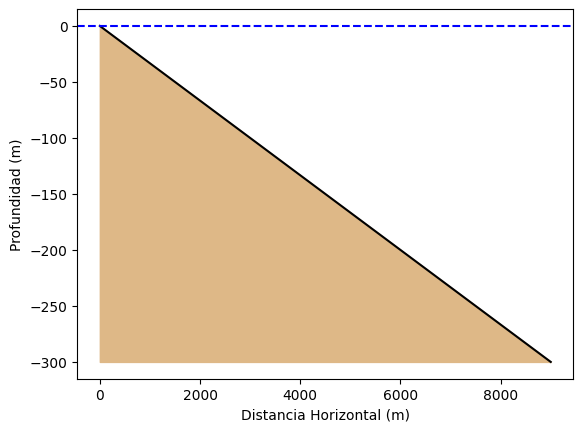

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define la distancia horizontal (eje x) desde 9000 a 0
x = np.linspace(9000, 0, 9000)

# Calcula la elevación (eje y) con la profundidad de 300 m en x=9000 y 0 m en x=0
h = -300 * (x / 9000)  # Pendiente calculada para cumplir con las profundidades

# Beach Profile
fig, ax1 = plt.subplots()
ax1.plot(x, h, color='black', label='Perfil de Playa')
ax1.fill_between(x, h, min(h), color='burlywood')  # Fill below the line
ax1.axhline(y=0, color='blue', linestyle='--', label='Nivel Medio del Mar')
ax1.set_xlabel("Distancia Horizontal (m)")
ax1.set_ylabel("Profundidad (m)")

## **2. Determinar la altura de ola, la profundidad y el ángulo final en rotura.**

Calcularemos los procesos de transformación del oleaje a medida que este se acerca mas a la costa, ocurren 2 fenomenos principalmente, el de asomeramiento y refracción, para este caso las olas entran con un ángulo de 30 grados con respecto a una linea perpendicular a la costa. para el proceso de refracción usaremos la ley de Snell ya esta es valida en el caso de que las lineas de igual profundidad sean paralelas, la ley de Snell relaciona los ángulos de incidencia y las velocidades de la onda a medida que esta se transforma de la sigiente manera

$$\frac{sin({\theta}_0)}{C_0} = \frac{sin({\theta})}{C}$$

Notemos que tenemos la celeridad de la onda en cada punto de su trayecto ya que somos capaces de calcular la longitud de onda manteniendo la frecuencia constante usando la relación de dispersión, por lo tanto el cambio en el ángulo puede ser calculado de manera sencilla.

Para el proceso de asomeramiento, se considera la conservacion de la energia, a medida que la onda entra en aguas someras tanto velocidad de fase como la velocidad de grupo se acercan a cero por lo tanto pierden energia cinética constantemente, es por esto que la onda gana altura para conservar la energía total, si utilizamos este argumento en un volumen de control rectangular y analizamos la onda que entra y la que sale podemos llegar a la siguiente expresión:

$$H_2 = \sqrt{\frac{C_{g2}}{C_{g1}}}H1 = K_s \cdot H1$$

Donde $C_{g}$ es la celeridad de grupo y al coeficiente $k_s$ se le llama coeficiente de asomeramiento, Si ambos procesos ocurren a la vez, como es el caso, la altura de ola total es afectada por 2 coeficientes uno que da cuenta del asomeramiento puro y otro que da cuenta de la refracción.

$$H_2 = \sqrt{\frac{cos({\theta}_0)}{cos({\theta}_1)}} \cdot \sqrt{\frac{C_{g2}}{C_{g1}}}H1 = K_r \cdot K_s \cdot H1$$

La función de la siguiente celda calcula estos coeficientes y el angulo a medida que la onda se acerca a la costa.

In [ ]:
def vel_and_coeffs(H,T,h_):
  c = []
  n = []
  for i in h_:
    L = longitud_onda(T, -i)
    C = L/T
    k = 2*np.pi/L
    n.append(1/2*(1+((2*k*-i)/np.sinh(2*k*-i))))
    c.append(C)

  c_ = c[0]
  ct = np.sin(30*np.pi/180)/c_
  theta = np.arcsin(ct*np.array(c))

  Cg = np.array(n)[:-1]*np.array(c)[:-1]
  ks = np.sqrt(Cg[:-1]/Cg[1:])
  Th = theta[:-1]
  kr = np.sqrt(np.cos(Th[:-1])/np.cos(Th[1:]))
  return c, theta, ks, kr

c1, theta1, ks1, kr1 = vel_and_coeffs(Hs1, Tp1, h)
c4, theta4, ks4, kr4 = vel_and_coeffs(Hs4, Tp4, h)
c7, theta7, ks7, kr7 = vel_and_coeffs(Hs7, Tp7, h)

<ipython-input-53-ed0af2fd79cc>:19: RuntimeWarning: divide by zero encountered in divide
  return (g * Tp**2) / (2 * np.pi) - L / np.tanh(2 * np.pi * profundidad / L)
<ipython-input-53-ed0af2fd79cc>:26: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  longitud_onda = fsolve(dispersion, L0)[0]
<ipython-input-58-956bb62c48f4>:8: RuntimeWarning: invalid value encountered in scalar divide
  n.append(1/2*(1+((2*k*-i)/np.sinh(2*k*-i))))


En esta celda graficamos el proceso de refracción de la onda, el eje y es el ángulo medido con respecto a la linea perpendicular a la costa y el eje x es la distancia desde la costa hacia aguas adentro.

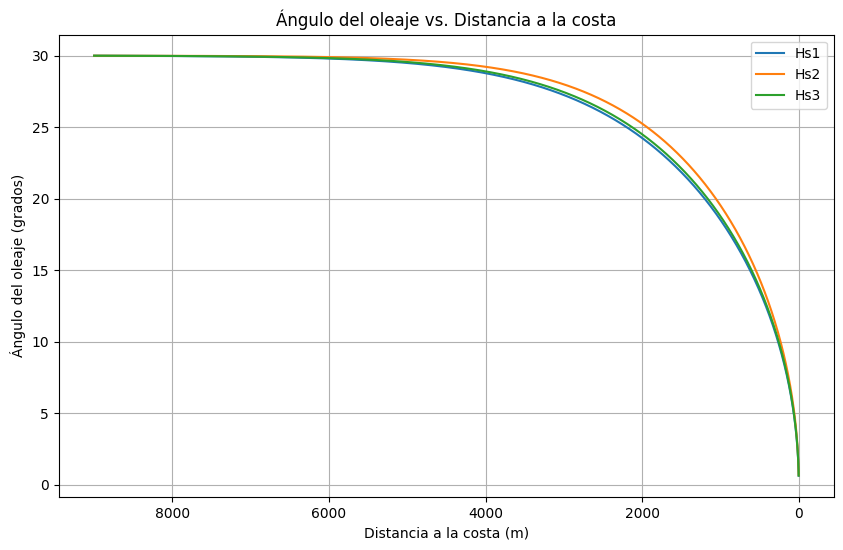

In [ ]:
Th1 = theta1[:-1]*180/np.pi
Th4 = theta4[:-1]*180/np.pi
Th7 = theta7[:-1]*180/np.pi
# plt.show()
plt.figure(figsize=(10, 6))
plt.plot(x[:-1], Th1, label = 'Hs1')
plt.plot(x[:-1], Th4, label ="Hs2")
plt.plot(x[:-1], Th7, label ="Hs3")
plt.xlabel('Distancia a la costa (m)')
plt.ylabel('Ángulo del oleaje (grados)')
plt.title('Ángulo del oleaje vs. Distancia a la costa')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invertir el eje x para que la costa esté a la izquierda
plt.show()


A continuacion usaremos los coeficientes calculados para encontrar la altura de ola según la teoría lineal, es de notarse que la altura de ola naturalmente crecera desmesuradamente a medida que nos acercamos a profundidad nula, obviamente la teoría lineal de ondas no es valida mucho antes de esto ya que ocurre otro proceso llamado rotura de la onda, el cual calcularemos. En las 2 celdas siguientes calcularemos con la función *shoaling* el asomeramiento usando los coeficientes y en la celda siguiente graficaremos la situación para las alturas de onda de las horas 1, 4 y 7 encontradas con el metodo espectral.

In [ ]:
# Asomeramiento de las ondas usando los coeficientes
def shoaling(hs,xx,kss,krr):
  # no consideramos el ultimo punto en x ya que la profundidad
  # es cero el resltado de h tiene 1 dato menos que x
  H_values=[]
  for i in range(len(xx[:-1])):
    if i==0:
      H_values.append(hs)
    else:
      Hi=H_values[i-1]*kss[i-1]*krr[i-1]
      H_values.append(Hi)
  return np.array(H_values)

H1 = shoaling(Hs1,x,ks1,kr1)
H4 = shoaling(Hs4,x,ks4,kr4)
H7 = shoaling(Hs7,x,ks7,kr7)

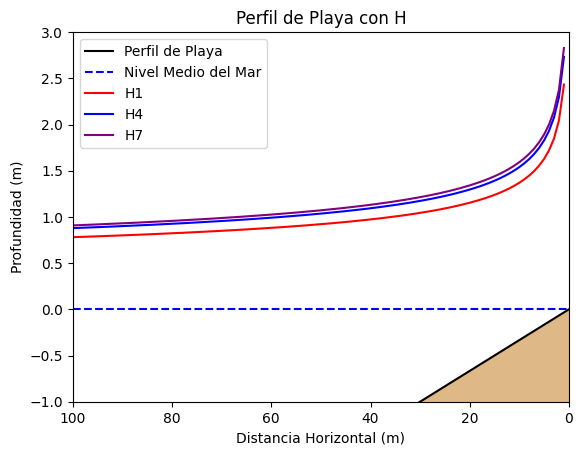

In [ ]:
# --- Plotting ---

fig, ax1 = plt.subplots()

# Beach Profile
ax1.plot(x, h, color='black', label='Perfil de Playa')
ax1.fill_between(x, h, min(h), color='burlywood')  # Fill below the line
ax1.axhline(y=0, color='blue', linestyle='--', label='Nivel Medio del Mar')
ax1.set_xlabel("Distancia Horizontal (m)")
ax1.set_ylabel("Profundidad (m)")

# H values on secondary y-axis
ax1.plot(x[:-1], H1, color='red', label='H1')
ax1.plot(x[:-1], H4, color='blue', label='H4')
ax1.plot(x[:-1], H7, color='purple', label='H7')
ax1.set_ylim(-1, 3)
ax1.set_xlim(0, 100)
ax1.invert_xaxis()
plt.legend()
plt.title("Perfil de Playa con H")
plt.show()

A continuacion calcularemos utilizando los criterios de Goda y McCowan el punto de rotura de la onda, esto es el punto en donde la onda no es capaz de soportar su propio peso debido al crecimiento de esta por los procesos antes vistos y en donde hay una liberación y disipación de la energía.

Según Goda la onda rompe cuando la relación

$$H_b/h_b = 0.78$$

Según McCowan la onda rompe cuando se cumple la relación

$$\frac{H_b}{L_0} = 0.17 \bigg[1-exp\bigg(\frac{-1.5\cdot \pi \cdot h_b}{L_0}(1+15tan(4/3 \beta))\bigg)\bigg]$$

Las 2 funciones siguientes calculan el lugar en donde ocurre la rotura según estos 2 autores.

In [ ]:
import numpy as np

# McCowan
def McCowan(Hb,hb):
  e = Hb/-hb
  idx = np.where(e >= 0.78)[0]
  return min(idx)

# GODA
def goda(Hb, L, hb, beta):
  # Make sure Hb, hb, and beta have the same length
  min_len = min(len(Hb), len(hb), len(beta))
  Hb = Hb[:min_len]
  hb = hb[:min_len]
  beta = beta[:min_len]
  val = Hb - L * 0.17 * (1 - np.exp((-1.5 * np.pi * -hb / L) * (1 + 15 * np.tan(beta) ** (4/3))))
  return min(np.where(np.abs(val) == min(np.abs(val)))[0])

A continuacion calculamos la altura de ola, la profundidad y el ángulo final en rotura. ademas de realizar una grafica en donde se presente esta informacion segun los criterios de Goda y McCowan. de aqui en adelante solo haremos los calculos para la altura de ola y periodo pico correspondientes a la hora 4 de los datos

$H_s = 0.633 m \quad$ y $\quad Tp = 15.754 s$

Segun McCowan
Altura de ola 1.0870679776286503- profundidad 1.3668185353927886 - Angulo final 4.253532041773332 x - 41.00455606178366
Segun Goda
Altura de ola 1.1638004428059578- profundidad 1.033448160906725 - Angulo final 3.7011313881286894 x - 31.003444827201747


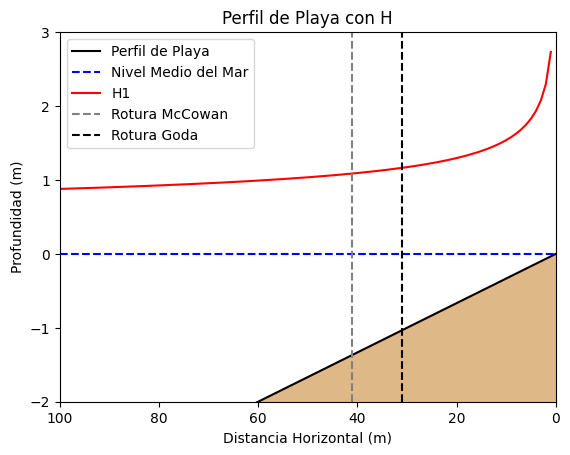

In [ ]:
## Fijemos parametros para una ola especifica
H = H4
L = longitud_onda_4
Th = theta4[:-1]

# --- Plotting ---
idxg = goda(H, L, h[:-1], Th)
idxm = McCowan(H, h[:-1])
print("Segun McCowan")
print(f"Altura de ola {H[idxm]}- profundidad {-h[idxm]} - Angulo final {Th[idxm]*180/np.pi} x - {x[idxm]}")
print("Segun Goda")
print(f"Altura de ola {H[idxg]}- profundidad {-h[idxg]} - Angulo final {Th[idxg]*180/np.pi} x - {x[idxg]}")
fig, ax1 = plt.subplots()

# Beach Profile
ax1.plot(x, h, color='black', label='Perfil de Playa')
ax1.fill_between(x, h, min(h), color='burlywood')  # Fill below the line
ax1.axhline(y=0, color='blue', linestyle='--', label='Nivel Medio del Mar')
ax1.set_xlabel("Distancia Horizontal (m)")
ax1.set_ylabel("Profundidad (m)")

# H values on secondary y-axis
ax1.plot(x[:-1], H, color='red', label='H1')
plt.axvline(x=x[idxm], color='gray', linestyle='--', label='Rotura McCowan')
plt.axvline(x=x[idxg], color='black', linestyle='--', label='Rotura Goda')
ax1.set_ylim(-2, 3)
ax1.set_xlim(0, 100)
ax1.invert_xaxis()
plt.legend()
plt.title("Perfil de Playa con H")
plt.show()



Los resultados obtenidos son

Segun Goda

$$\textbf{Altura de ola} = 1.16\,m$$
$$\textbf{Profundiad} = 1.03\,m$$
$$\textbf{Angulo final} = 3.70\,deg$$
$$\textbf{Distancia desde la costa} = 31 \,m$$

Segun Goda

$$\textbf{Altura de ola} = 1.08\,m$$
$$\textbf{Profundiad} = 1.36\,m$$
$$\textbf{Angulo final} = 4.25\,deg$$
$$\textbf{Distancia desde la costa} = 41 \,m$$

#**TAREA 4**

1. En esta práctica se estudia la evolución de una onda después del punto de rotura, basado en decaimiento lineal desde el punto de rotura hasta llegar a la costa con disipación total igual a cero, tal como se muestra en la figura.

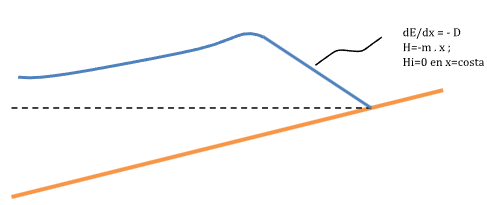

2. Basado en la ecuaciones de hidrodinámica (conservación de la masa y cantidad de movimiento) promediadas en vertical o NLSWE (Non-Linear Shallow Water Equations) con inclusión del tensor de radiación,  calcular la sobreelevación de set-up (η) asumiendo que las velocidades son despreciables. Calcular Sxx (Tensor de radiación) basado en teoría lineal.

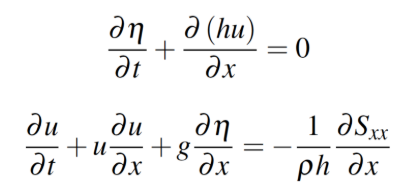


La segunda ecuacion puede ser resuelta para la variacion media de la superficie del agua y asumiendo linealidad en el tensor de radiacion y que la magnitud de la velocidad es despreciable, empleando estas hipotesis llegamos a las siguientes ecuaciones
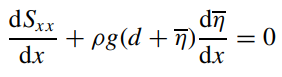

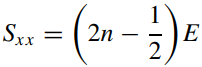

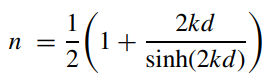

#$E = \frac{1}{8}\rho g H^2$

Haciendo una integracion de la primera ecuacion usando los valores del tensor de radiacion lineal obtenemos el siguiente resultado para el setdown, es decir valida hasta el punto en donde rompe la onda. utilizaremos esta solucion para calcular el setdown hasta el punto de rotura.

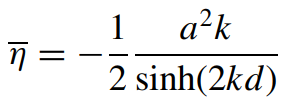

Despues del punto de rotura debemos asumir un perfil onda en rotura, asumiremos que este perfil es lineal (una linea recta) hasta llegar a la costa, para el setdown otra hipotesis clave es la de que asumimos que estamos en aguas lo suficientemente someras para que las ondas sean no dispersivas, en este caso el coeficiente $n = 1$, por lo tanto

$$S_{xx} = \frac{3}{2}E = \frac{3}{16}\rho g H^2$$

Ademas el perfil lineal nos permite simplificar aun mas la ecuacion diferencial hasta llegar a

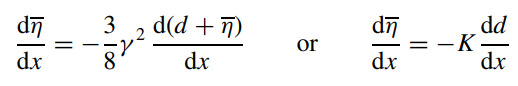

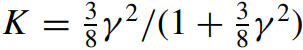

Podemos llegar a una solucion de esta ecuacion diferencial simplemente integrando a ambos lados encontrando

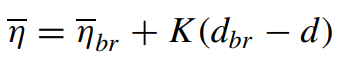

En esta ecuacion $\eta_{br}$ es el nivel medio en la rotura, $d_{br}$ es la profundidad en la rotura, Finalmente tenemos 2 ecuaciones para el nivel medio del agua una aplicable antes de la rotura y otra despues de esta las ecuaciones son

Antes de la rotura (set-down)
$$\overline{\eta} = -\frac{1}{8}\frac{H^2 k}{sinh(2kd)}$$

Despues de la rotura (set-up)
$$\overline{\eta} =\overline{\eta}_{br} = K(d_{br}-d)$$

Donde
$$K = \frac{3}{8}{\gamma}^2/(1+\frac{3}{8}{\gamma}^2)$$

Donde ademas $\gamma$ es la tasa de decrecimento lineal de la altura de ola siendo esta funcion solo de la profundidad local (decrecimento lineal).

$$H = \gamma(d + \overline{\eta})$$

Realizando el calculo en nuestro caso $\gamma = 1.12$, con estos datos procedemos a calcular el el *Set-Down* y *Set-Up*, Presentaremos el resultado en el formato de una gráfica.

<ipython-input-80-fb3dca1c755a>:21: RuntimeWarning: invalid value encountered in divide
  gamma=H_su/h_su


1.1261333532055102


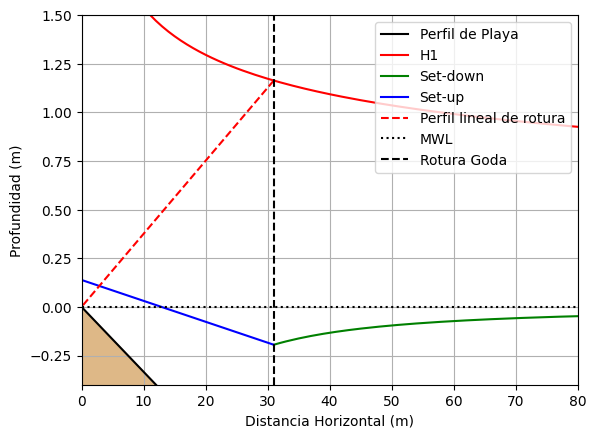

In [ ]:
def setu_setd(Hb,L,hb,beta,br_type):
  #calculamos el set down utilizando la teoria lineal
  #calculo del set up utilizando la teoria lineal (en el tensor de radiacion)

  if br_type == 'goda':
    idx = goda(Hb, L, hb, beta)

  elif br_type == 'mcowan':
    idx = McCowan(Hb,hb)

  H_sd=H1[:idx+1]
  h_sd=-h[:idx+1]
  #set_d=np.power(H_sd,2)/(16*h_sd)
  kk = 2*np.pi/L
  set_d=-3*(np.power(H_sd,2)*kk)/(8*np.sinh(2*h_sd*kk))
  set_d1=-3*np.power(H_sd,2)/(16*h_sd)
  ##
  m=(Hb[idx]-0)/(x[idx]-0)
  H_su=m*x[idx:]
  h_su=-h[idx:]
  gamma=H_su/h_su
  print(gamma[0])
  K=-3*gamma[0]**2/(3*gamma[0]**2+8)
  set_u=K*(h_su+h[idx])+set_d[-1]
  return idx, H_su, set_d, set_u

idx, H_su, set_d, set_u = setu_setd(H,L,h,Th,'goda')
mean_level = np.mean(todos)
# --- Plotting ---

fig, ax1 = plt.subplots()

# Beach Profile
ax1.plot(x, h, color='black', label='Perfil de Playa')
ax1.fill_between(x, h, min(h), color='burlywood')  # Fill below the line
# ax1.axhline(y=0, color='blue', linestyle='--', label='Nivel Medio del Mar')
ax1.set_xlabel("Distancia Horizontal (m)")
ax1.set_ylabel("Profundidad (m)")

# H values on secondary y-axis
ax1.plot(x[:-1], H, color='red', label='H1')
ax1.plot(x[:idx+1], set_d, color='green', label='Set-down')
ax1.plot(x[idx:], set_u, color='blue', label='Set-up')
ax1.plot(x[idx:],H_su, color='red',linestyle='--',label='Perfil lineal de rotura')
plt.axhline(y=mean_level, color='black', linestyle=':', label='MWL')
plt.axvline(x=x[idxg], color='black', linestyle='--', label='Rotura Goda')
ax1.set_ylim(-0.4, 1.5)
ax1.set_xlim(0, 80)
plt.legend(loc = "upper right")
plt.grid()
plt.show()